In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter('ignore')

In [2]:
# Hyperparameters
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS = 3
EPOCHS = 100

In [3]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "C:\\Users\\basel\\Rice_Leaf_AUG",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3829 files belonging to 6 classes.


In [4]:
# Split dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [5]:
class_names = dataset.class_names
class_names

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Sheath Blight']

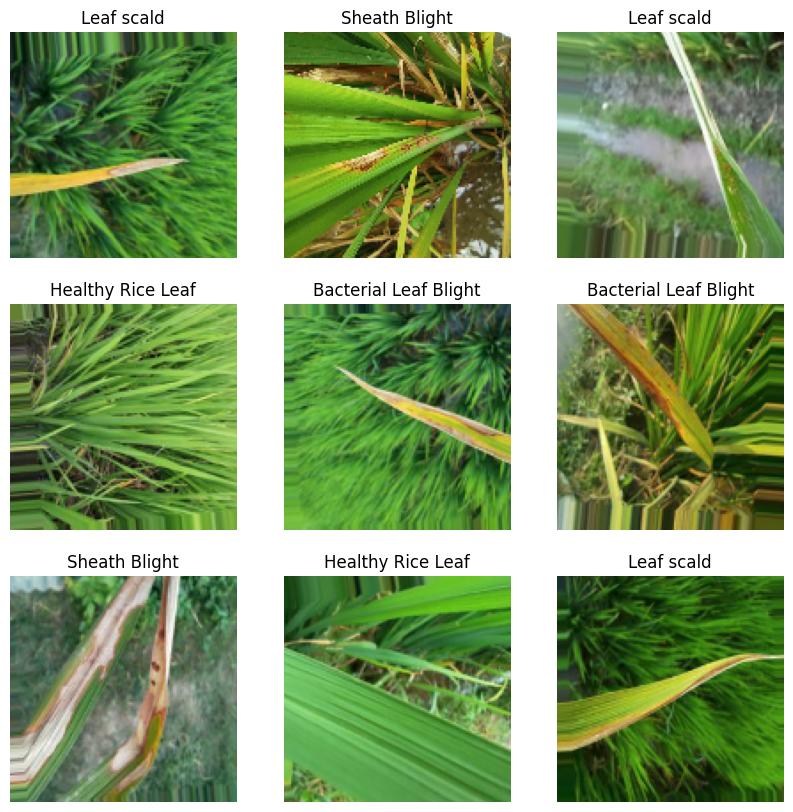

In [6]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Normalize dataset
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Augmentation block
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])
# Apply augmentation to train_ds only
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
# Deep CNN Architecture for Image Classification with Softmax Output
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # Adjust according to the number of classes
])

In [10]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True)
]

In [12]:
#Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/100
96/96 [==============================] - 28s 137ms/step - loss: 1.6599 - accuracy: 0.2917 - val_loss: 1.5315 - val_accuracy: 0.3438
Epoch 2/100
96/96 [==============================] - 19s 143ms/step - loss: 1.4189 - accuracy: 0.4247 - val_loss: 1.2350 - val_accuracy: 0.4844
Epoch 3/100
96/96 [==============================] - 18s 130ms/step - loss: 1.3163 - accuracy: 0.4721 - val_loss: 1.1711 - val_accuracy: 0.5521
Epoch 4/100
96/96 [==============================] - 19s 136ms/step - loss: 1.2220 - accuracy: 0.5181 - val_loss: 1.0893 - val_accuracy: 0.5703
Epoch 5/100
96/96 [==============================] - 20s 146ms/step - loss: 1.1634 - accuracy: 0.5550 - val_loss: 1.1190 - val_accuracy: 0.5703
Epoch 6/100
96/96 [==============================] - 19s 138ms/step - loss: 1.1231 - accuracy: 0.5727 - val_loss: 0.9240 - val_accuracy: 0.6771
Epoch 7/100
96/96 [==============================] - 21s 161ms/step - loss: 1.1169 - accuracy: 0.5802 - val_loss: 0.9214 - val_accuracy:

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy = {test_acc * 100:.2f}%")

12/12 [==============================] - 6s 22ms/step - loss: 0.1919 - accuracy: 0.9271
✅ Test Accuracy = 92.71%


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)     

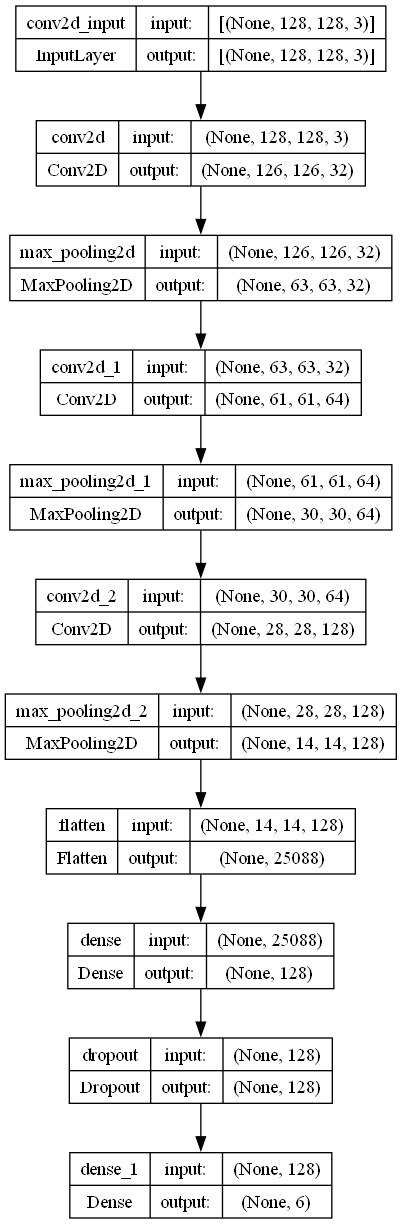

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

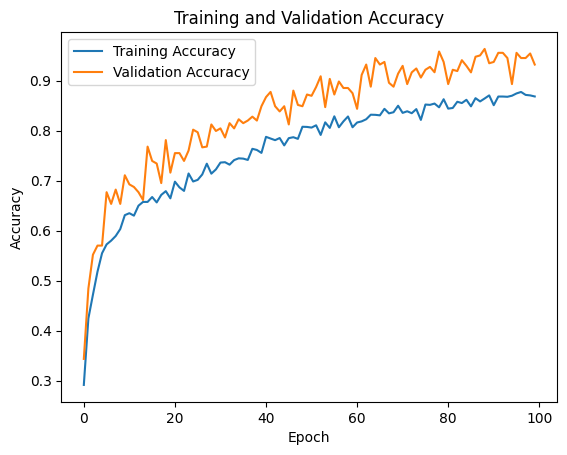

In [21]:
#Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

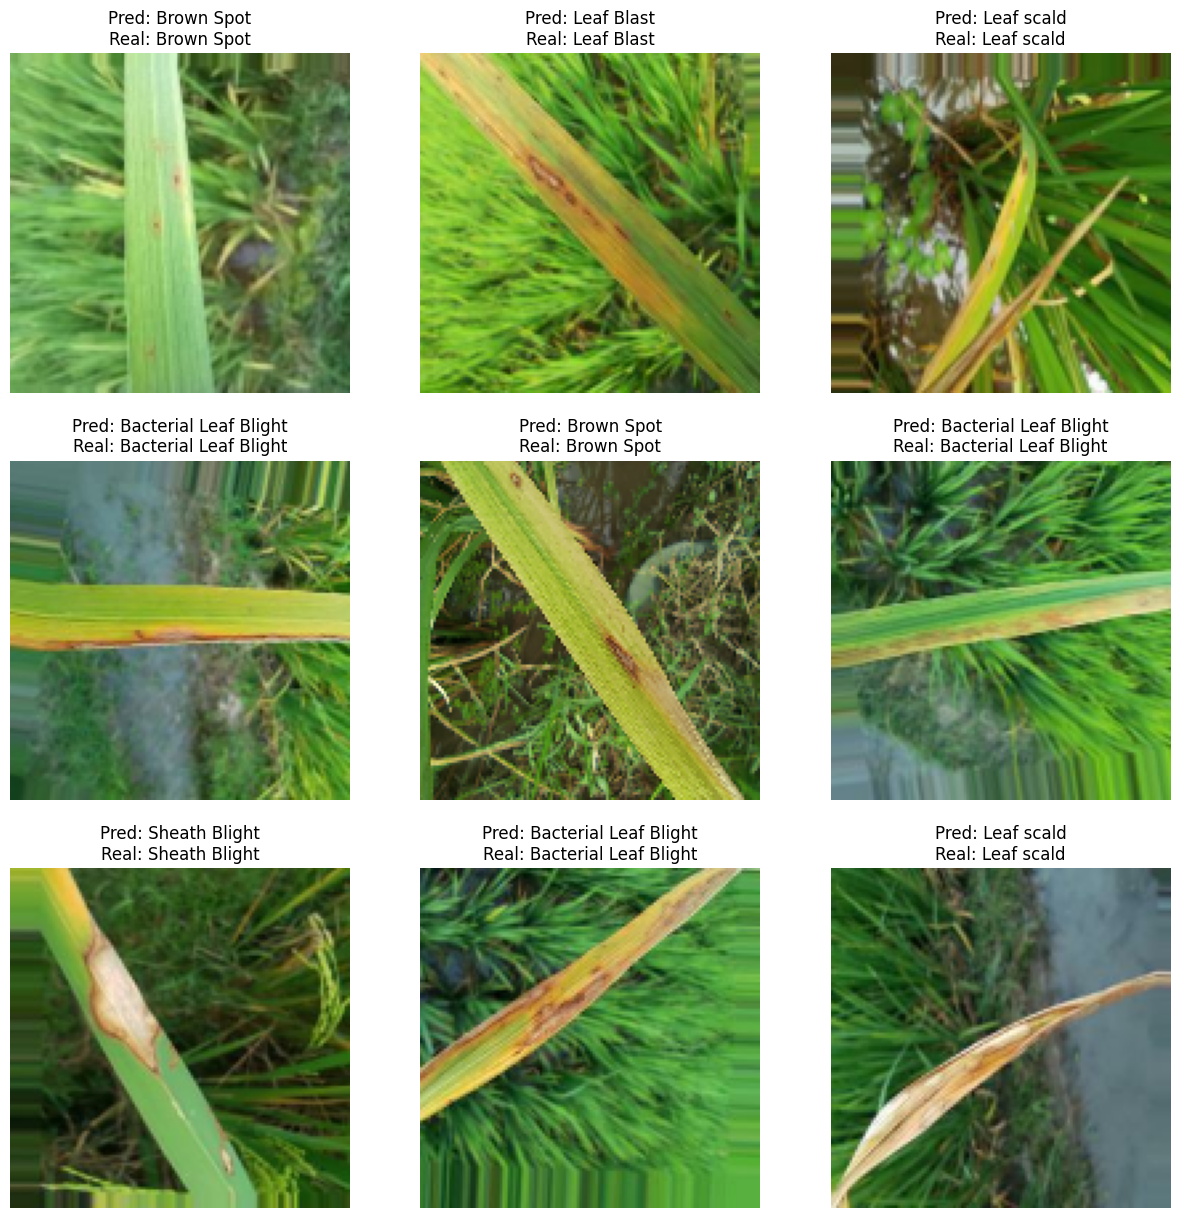

In [29]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    classifications = model(images)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        # Ensure the image is in the correct range and format
        img = images[i].numpy()
        
        # If images are normalized to [0, 1], scale to [0, 255]
        if img.max() <= 1.0:
            img = img * 255.0
        
        # Clip values to ensure they're in [0, 255] and cast to uint8
        img = np.clip(img, 0, 255).astype("uint8")
        
        # Display the image
        plt.imshow(img)
        
        # Get predicted and true labels
        index = np.argmax(classifications[i])
        plt.title(f"Pred: {class_names[index]}\nReal: {class_names[labels[i]]}")
        
        # Optional: Remove axis for cleaner display
        plt.axis("off")

plt.show()

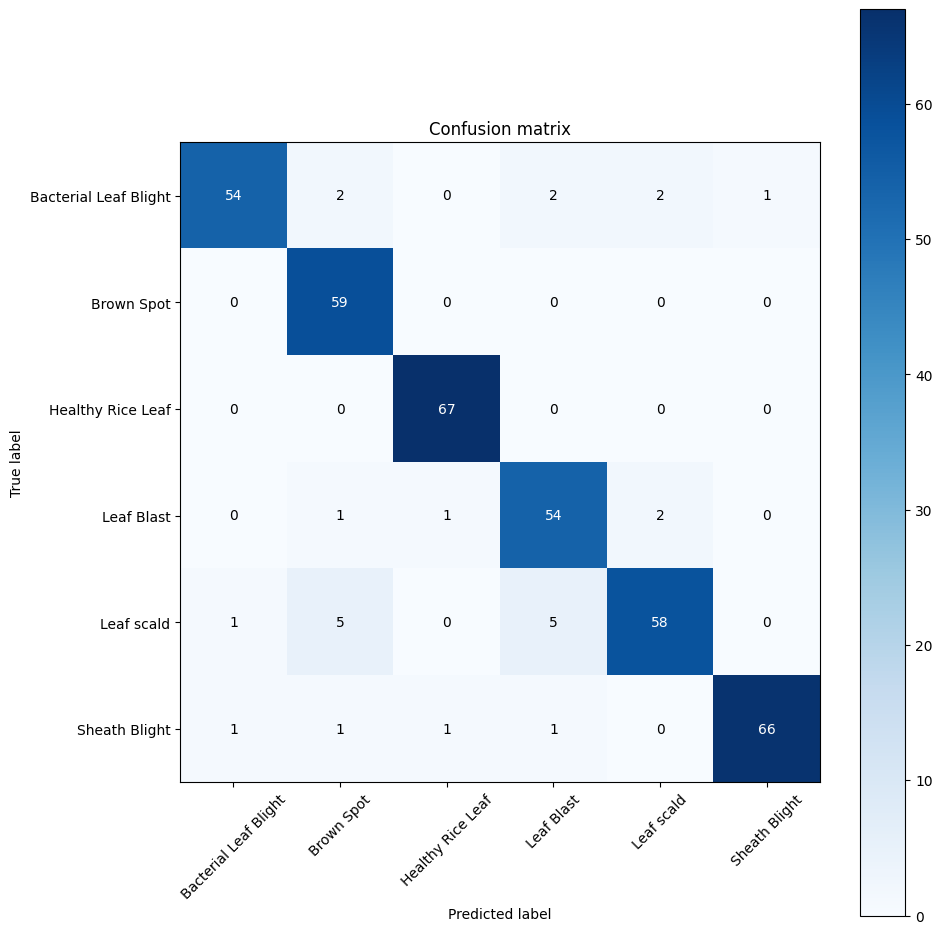

In [28]:
all_predicted_labels = []
all_actual_labels = []

for images, labels in test_ds:
    classifications = model(images)
    predicted_labels = [np.argmax(classification) for classification in classifications.numpy()]
    all_predicted_labels.extend(predicted_labels)
    all_actual_labels.extend(labels.numpy())

#Create confusion matrix
conf_matrix = confusion_matrix(all_actual_labels, all_predicted_labels)

 #Plot confusion matrix with numbers
plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')


thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [30]:
# model.save('rice_leaf_disease_model')  #save model

INFO:tensorflow:Assets written to: rice_leaf_disease_model\assets


INFO:tensorflow:Assets written to: rice_leaf_disease_model\assets
